In [1]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.9 MB/s eta 0:00:00


In [2]:
from collections import namedtuple
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

import faiss
import numpy as np
import pandas as pd
import plotly.express as px

from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from IPython.core.display import display,HTML

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
base_dir = '/content/gdrive/MyDrive/Face Detection and Recognition with NPU'

# ArcFace (IR-SE Model)

In [ ]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.batch_norm = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = x.reshape(x.size(0), -1)
        # x = self.flatten(x)
        return x

# Test
model = CustomModel()
input_tensor = torch.randn(1, 512, 7, 7)  # Example input
output = model(input_tensor)

print("Output shape:", output.shape)  # Should be [1, 512 * 7 * 7] = [1, 25088]

In [36]:
class CustomMaxPool2d(nn.Module):
    def __init__(self, in_channels, kernel_size, stride):
        super(CustomMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.dw_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=self.stride, groups=in_channels, bias=False)
        # 가중치 초기화: 모든 필터를 1로 설정
        with torch.no_grad():
            self.dw_conv.weight.fill_(1.0)
    def forward(self, x):
        if self.stride > 1 :
            return self.dw_conv(x)
        else :
            return x

class ReshapeAndFlatten(nn.Module):
    def __init__(self):
        super(ReshapeAndFlatten, self).__init__()
        # self.flatten = nn.Flatten(start_dim=1)
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        # x = self.flatten(x)
        return x

In [35]:
# ArcFace helper functions
class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
	""" A named tuple describing a ResNet block. """

def l2_norm(input, axis=1):
	norm = torch.norm(input, 2, axis, True)
	output = torch.div(input, norm)
	return output

def get_block(in_channel, depth, num_units, stride=2):
	return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
	if num_layers == 50:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=4),
			get_block(in_channel=128, depth=256, num_units=14),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 100:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=13),
			get_block(in_channel=128, depth=256, num_units=30),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 152:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=8),
			get_block(in_channel=128, depth=256, num_units=36),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	else:
		raise ValueError("Invalid number of layers: {}. Must be one of [50, 100, 152]".format(num_layers))
	return blocks


class SEModule(nn.Module):
	def __init__(self, channels, reduction):
		super(SEModule, self).__init__()
		self.avg_pool = nn.AdaptiveAvgPool2d(1)
		self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0, bias=False)
		self.relu = nn.ReLU(inplace=True)
		self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, padding=0, bias=False)
		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		module_input = x
		x = self.avg_pool(x)
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.sigmoid(x)
		return module_input * x


class bottleneck_IR(nn.Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = CustomMaxPool2d(in_channel,1, stride)
		else:
			self.shortcut_layer = nn.Sequential(
				nn.Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				nn.BatchNorm2d(depth)
			)
		self.res_layer = nn.Sequential(
			nn.BatchNorm2d(in_channel),
			nn.Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False), nn.PReLU(depth),
			nn.Conv2d(depth, depth, (3, 3), stride, 1, bias=False), nn.BatchNorm2d(depth)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class bottleneck_IR_SE(nn.Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR_SE, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = CustomMaxPool2d(in_channel,1, stride)
		else:
			self.shortcut_layer = nn.Sequential(
				nn.Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				nn.BatchNorm2d(depth)
			)
		self.res_layer = nn.Sequential(
			nn.BatchNorm2d(in_channel),
			nn.Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
			nn.PReLU(depth),
			nn.Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
			nn.BatchNorm2d(depth),
			SEModule(depth, 16)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut

In [37]:
class Backbone(nn.Module):
	def __init__(self, input_size, num_layers, mode='ir_se', drop_ratio=0.6, affine=True):
		super(Backbone, self).__init__()
		assert input_size in [112, 224], "input_size should be 112 or 224"
		assert num_layers in [50, 100, 152], "num_layers should be 50, 100 or 152"
		assert mode in ['ir', 'ir_se'], "mode should be ir or ir_se"
		blocks = get_blocks(num_layers)
		if mode == 'ir':
			unit_module = bottleneck_IR
		elif mode == 'ir_se':
			unit_module = bottleneck_IR_SE
		self.input_layer = nn.Sequential(nn.Conv2d(3, 64, (3, 3), 1, 1, bias=False),
									  nn.BatchNorm2d(64),
									  nn.PReLU(64))
		if input_size == 112:
			self.output_layer = nn.Sequential(nn.BatchNorm2d(512),
			                               nn.Dropout(drop_ratio),
			                               ReshapeAndFlatten(),
			                               nn.Linear(512*7*7, 512),
			                               nn.BatchNorm1d(512, affine=affine))
		else:
			self.output_layer = nn.Sequential(nn.BatchNorm2d(512),
			                               nn.Dropout(drop_ratio),
																		 ReshapeAndFlatten(),
			                               nn.Linear(512 * 14 * 14, 512),
			                               nn.BatchNorm1d(512, affine=affine))

		modules = []
		for block in blocks:
			for bottleneck in block:
				modules.append(unit_module(bottleneck.in_channel,
										   bottleneck.depth,
										   bottleneck.stride))
		self.body = nn.Sequential(*modules)

	def forward(self, x):
		x = self.input_layer(x)
		x = self.body(x)
		x = self.output_layer(x)

		return x

def IR_SE_50(input_size):
	"""Constructs a ir_se-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir_se', drop_ratio=0.4, affine=False)
	return model



In [46]:
import torch
import torch.nn as nn

def replace_prelu_with_leakyrelu(model, prelu_to_leakyrelu=True):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            replace_prelu_with_leakyrelu(module, prelu_to_leakyrelu)

        if isinstance(module, nn.PReLU) and prelu_to_leakyrelu:
            # Calculate the average of the PReLU weights for negative_slope
            negative_slope = module.weight.mean().item()
            leaky_relu = nn.LeakyReLU(negative_slope=negative_slope, inplace=True)
            setattr(model, name, leaky_relu)

    return model

# class StaticBatchNorm2d(nn.Module):
#     def __init__(self, bn_layer):
#         super(StaticBatchNorm2d, self).__init__()
#         self.weight = bn_layer.weight.detach().clone()
#         self.bias = bn_layer.bias.detach().clone()
#         self.running_mean = bn_layer.running_mean.detach().clone()
#         self.running_var = bn_layer.running_var.detach().clone()
#         self.eps = bn_layer.eps

#     def forward(self, x):
#         return self.weight[None, :, None, None] * (x - self.running_mean[None, :, None, None]) / torch.sqrt(self.running_var[None, :, None, None] + self.eps) + self.bias[None, :, None, None]

# class StaticBatchNorm1d(nn.Module):
#     def __init__(self, bn_layer):
#         super(StaticBatchNorm1d, self).__init__()
#         self.running_mean = bn_layer.running_mean.detach().clone()
#         self.running_var = bn_layer.running_var.detach().clone()
#         self.eps = bn_layer.eps

#     def forward(self, x):
#         return (x - self.running_mean[None, :]) / torch.sqrt(self.running_var[None, :] + self.eps)
# runntime 연산 시 Add, Div, Mul 노드 생성

class StaticBatchNorm2d(nn.Module):
    def __init__(self, bn_layer):
        super(StaticBatchNorm2d, self).__init__()
        self.a = (bn_layer.weight / torch.sqrt(bn_layer.running_var + bn_layer.eps)).detach()
        self.b = (bn_layer.bias - self.a * bn_layer.running_mean).detach()

    def forward(self, x):
        return x * self.a[None, :, None, None] + self.b[None, :, None, None]

class StaticBatchNorm1d(nn.Module):
    def __init__(self, bn_layer):
        super(StaticBatchNorm1d, self).__init__()
        self.a = (bn_layer.weight / torch.sqrt(bn_layer.running_var + bn_layer.eps)).detach()
        self.b = (bn_layer.bias - self.a * bn_layer.running_mean).detach()

    def forward(self, x):
        return x * self.a[None, :] + self.b[None, :]



def replace_batchnorm_with_static(model):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            setattr(model, name, StaticBatchNorm2d(module))
        elif isinstance(module, nn.BatchNorm1d):
            setattr(model, name, StaticBatchNorm1d(module))
        else:
            replace_batchnorm_with_static(module)

# 모델 로드 및 수정
model = Backbone(input_size=112, num_layers=50, mode='ir_se')
checkpoints = torch.load(os.path.join(base_dir, 'model_ir_se50.pth'), map_location=torch.device(device))
missing_keys, unexpected_keys = model.load_state_dict(checkpoints, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected Keys:", unexpected_keys)
for key in missing_keys:
    layer_name = key.rsplit('.', 1)[0]  # 'shortcut_layer.weight'에서 'shortcut_layer' 추출
    module = dict(model.named_modules()).get(layer_name)
    if module and hasattr(module, "weight"):
        nn.init.constant_(module.weight, 1.0)  # 가중치를 1로 초기화
        print(f"Initialized {layer_name}")

from copy import deepcopy

# PReLU -> LeakyReLU 교체
# modified_model = replace_prelu_with_leakyrelu(deepcopy(model))
# replace_batchnorm_with_static(modified_model)

# 결과 확인
# print("Modified Model:", modified_model)

<ipython-input-46-e8ea7a77af6d>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load(os.path.join(base_dir, 'model_ir_se50.pth'), map_location=torch.de

Missing keys: ['body.0.shortcut_layer.dw_conv.weight', 'body.1.shortcut_layer.dw_conv.weight', 'body.2.shortcut_layer.dw_conv.weight', 'body.4.shortcut_layer.dw_conv.weight', 'body.5.shortcut_layer.dw_conv.weight', 'body.6.shortcut_layer.dw_conv.weight', 'body.8.shortcut_layer.dw_conv.weight', 'body.9.shortcut_layer.dw_conv.weight', 'body.10.shortcut_layer.dw_conv.weight', 'body.11.shortcut_layer.dw_conv.weight', 'body.12.shortcut_layer.dw_conv.weight', 'body.13.shortcut_layer.dw_conv.weight', 'body.14.shortcut_layer.dw_conv.weight', 'body.15.shortcut_layer.dw_conv.weight', 'body.16.shortcut_layer.dw_conv.weight', 'body.17.shortcut_layer.dw_conv.weight', 'body.18.shortcut_layer.dw_conv.weight', 'body.19.shortcut_layer.dw_conv.weight', 'body.20.shortcut_layer.dw_conv.weight', 'body.22.shortcut_layer.dw_conv.weight', 'body.23.shortcut_layer.dw_conv.weight']
Unexpected Keys: []
Initialized body.0.shortcut_layer.dw_conv
Initialized body.1.shortcut_layer.dw_conv
Initialized body.2.shortcut_

In [47]:
from torchsummary import summary

# 모델 요약 (입력 크기 지정 필요)
summary(model, input_size=(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
             PReLU-3         [-1, 64, 112, 112]              64
            Conv2d-4           [-1, 64, 56, 56]              64
   CustomMaxPool2d-5           [-1, 64, 56, 56]               0
       BatchNorm2d-6         [-1, 64, 112, 112]             128
            Conv2d-7         [-1, 64, 112, 112]          36,864
             PReLU-8         [-1, 64, 112, 112]              64
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
AdaptiveAvgPool2d-11             [-1, 64, 1, 1]               0
           Conv2d-12              [-1, 4, 1, 1]             256
             ReLU-13              [-1, 4, 1, 1]               0
           Conv2d-14             [-1, 6

MaxPool2D(Shortcut Layer) to Others(AvgPool2D, Slice, DW_Conv2D)

In [16]:
# 예제 입력
in_channels = 3
out_channels = 3
dummy_input = torch.randn(1, in_channels, 7, 7)

# Shortcut Layer 정의
shortcut_layer = CustomMaxPool2d(in_channels, kernel_size=1, stride=2)

# 출력 확인
output = shortcut_layer(dummy_input)
output_avg = nn.AvgPool2d(1,2)(dummy_input)
output_original = nn.MaxPool2d(1,2)(dummy_input)
dw_conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=2, groups=3, bias=False)  # bias=False로 설정

# 가중치 초기화: 모든 필터를 1로 설정
with torch.no_grad():
    dw_conv.weight.fill_(1.0)
dw_conv(dummy_input)

print("Input shape:", dummy_input.shape)
print(dummy_input)
print("Custom Output shape:", output.shape)
print(output)
print("AvgPool2d Output shape:", output_avg.shape)
print(output_avg)
print("Original Output shape:", output_original.shape)
print(output_original)
print("Depthwise Convolution Output shape:", dw_conv(dummy_input).shape)
print(dw_conv(dummy_input))



Input shape: torch.Size([1, 3, 7, 7])
tensor([[[[ 1.0241,  0.9020, -0.8203,  0.8236, -0.6876,  0.4878, -2.7691],
          [-0.9273,  1.8711,  1.1179,  0.3883,  0.3448, -1.2872,  0.1976],
          [ 0.8753,  2.1087, -0.3379, -1.7276, -0.5337, -0.0823, -0.4558],
          [ 0.8114,  0.8090,  0.7928,  0.9062, -0.0962,  1.1160,  0.8107],
          [ 0.2109, -0.0455,  0.6095, -1.1365,  0.3591, -0.0055,  0.9079],
          [-0.1409, -0.1151, -1.6969,  0.8197, -0.1275,  0.6893,  0.0918],
          [ 0.1777, -1.1042,  0.5181, -0.4071,  0.9956, -0.6210, -0.5504]],

         [[-0.6041,  0.4541, -1.3843, -0.5907, -1.2678, -2.1078,  0.5929],
          [-0.3559, -0.8921,  0.7021, -0.7199, -0.4763, -0.6630,  0.5925],
          [ 1.9722,  0.1071, -1.2127,  0.1670,  0.0213, -3.2746, -0.8126],
          [-0.8459, -0.9520,  0.5677,  0.8112,  0.2870,  1.3192,  0.5451],
          [ 0.7150, -1.8970, -0.5332, -0.6786,  3.2722, -0.2297,  0.0694],
          [ 0.9779,  0.4216,  0.4210,  0.9853, -1.6811,  0.6

Flatten to Reshape

In [11]:
# 더미 입력 데이터 생성
dummy_input = torch.randn(4, 512, 7, 7)  # (batch_size=1, channels=512, height=7, width=7)

flatten_layer = nn.Flatten()
flatten_output = flatten_layer(dummy_input)
flatten_to_reshape_layer = FlattenToReshape()
flatten_to_reshape_output = flatten_to_reshape_layer(dummy_input)

print("Input Shape:", dummy_input.shape)
print("nn.Flatten Output Shape:", flatten_output.shape)
print("FlattenToReshape Output Shape:", flatten_to_reshape_output.shape)

is_close = torch.allclose(flatten_output, flatten_to_reshape_output)
print("Outputs are identical:", is_close)


Input Shape: torch.Size([4, 512, 7, 7])
nn.Flatten Output Shape: torch.Size([4, 25088])
FlattenToReshape Output Shape: torch.Size([4, 25088])
Outputs are identical: True


# Extract Dataset

In [10]:
import zipfile

file_name = 'faces_webface_112x112.zip'
with zipfile.ZipFile(os.path.join(base_dir, file_name), 'r') as zip_ref:
    zip_ref.extractall('/content')

!ls -l /content/faces_webface_112x112

total 3173544
-rw-r--r-- 1 root root   76525089 Dec  9 05:53 agedb_30.bin
-rw-r--r-- 1 root root   74157257 Dec  9 05:52 calfw.bin
-rw-r--r-- 1 root root   87456541 Dec  9 05:53 cfp_ff.bin
-rw-r--r-- 1 root root   76267779 Dec  9 05:53 cfp_fp.bin
-rw-r--r-- 1 root root   62610952 Dec  9 05:53 cplfw.bin
-rw-r--r-- 1 root root   64738112 Dec  9 05:53 lfw.bin
-rw-r--r-- 1 root root         14 Dec  9 05:52 property
-rw-r--r-- 1 root root    8707814 Dec  9 05:53 train.idx
-rw-r--r-- 1 root root   73167925 Dec  9 05:53 train.lst
-rw-r--r-- 1 root root 2726043620 Dec  9 05:53 train.rec


In [ ]:
import zipfile

file_name = 'faces_umd.zip'
with zipfile.ZipFile(os.path.join(base_dir, file_name), 'r') as zip_ref:
    zip_ref.extractall('/content')

!ls -l /content/faces_umd

total 2541032
-rw-r--r-- 1 root root   76525089 Dec  5 18:07 agedb_30.bin
-rw-r--r-- 1 root root   79602255 Dec  5 18:07 cfp_fp.bin
-rw-r--r-- 1 root root   64738112 Dec  5 18:07 lfw.bin
-rw-r--r-- 1 root root         12 Dec  5 18:07 property
-rw-r--r-- 1 root root    6491521 Dec  5 18:07 train.idx
-rw-r--r-- 1 root root 2374639924 Dec  5 18:07 train.rec


In [11]:
import pickle, cv2

def load_bin(bin_path):
    with open(bin_path, 'rb') as f:
        bins, labels = pickle.load(f, encoding='bytes')
    images = [cv2.imdecode(np.frombuffer(b, dtype=np.uint8), cv2.IMREAD_COLOR) for b in bins]
    return images, labels

# LFW 데이터셋 로드
lfw_images, _ = load_bin('/content/faces_webface_112x112/lfw.bin')
print(f"LFW Images: {len(lfw_images)}")

LFW Images: 12000


Save Image

In [12]:
import cv2
import numpy as np

idx = 3

image_to_save = lfw_images[idx]

# 저장 경로 설정
save_path = f"lfw_image_{idx}.png"

# 이미지 저장 (PNG 형식)
cv2.imwrite(save_path, image_to_save)

print(f"Image saved to {save_path}")

Image saved to lfw_image_3.png


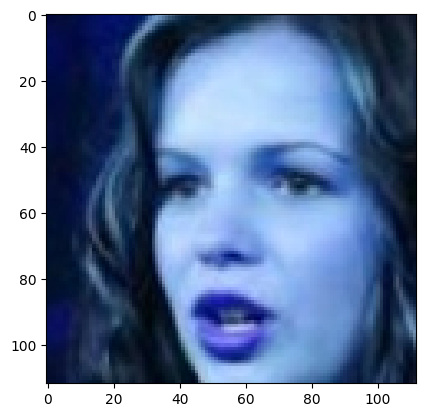

In [13]:
import matplotlib.pyplot as plt
plt.imshow(lfw_images[6])

# Create Featuremap

In [14]:
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class LFWDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

num_pairs = len(lfw_images) // 2
lfw_labels = np.repeat(range(num_pairs), 2).tolist()

processed_images = []
processed_labels = []
feature_maps = np.zeros((len(lfw_images)//600, 512))
feature_maps_mod = np.zeros((len(lfw_images)//600, 512))

print("Processing dataset with TQDM:")
modified_model.eval()
model.eval()

for idx in tqdm(range(len(lfw_images)//600), desc="Dataset Processing"):
    image = lfw_images[idx]
    label = lfw_labels[idx]
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        feature_maps[idx] = l2_norm(model(image_tensor)).detach().numpy()
    with torch.no_grad():
        feature_maps_mod[idx] = l2_norm(modified_model(image_tensor)).detach().numpy()

    processed_images.append(image)
    processed_labels.append(label)

Processing dataset with TQDM:


Dataset Processing: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


# Check image similarities

In [ ]:
tsne_ = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results_ = tsne_.fit_transform(feature_maps)

In [ ]:
import plotly.express as px
from PIL import Image
import numpy as np
import io
import base64

# t-SNE 결과와 라벨로 산점도 생성
fig = px.scatter(
    x=tsne_results_[:, 0],
    y=tsne_results_[:, 1],
    color=processed_labels,
    labels={"color": "Labels"}
)

# 이미지 추가
for d, img_tensor in zip(tsne_results_, processed_images):
    # processed_images에서 Tensor를 PIL 이미지로 변환
    img_pil = Image.fromarray(img_tensor)

    # PIL 이미지를 Base64로 인코딩
    buffer = io.BytesIO()
    img_pil.save(buffer, format="PNG")
    buffer.seek(0)
    img_base64 = base64.b64encode(buffer.read()).decode()

    # Plotly에 이미지 추가
    fig.add_layout_image(
        dict(
            source=f"data:image/png;base64,{img_base64}",
            x=d[0],
            y=d[1],
            xref="x",
            yref="y",
            xanchor="center",
            yanchor="middle",
            sizex=0.5,
            sizey=0.5,
        )
    )

# 그래프 표시
fig.show()

In [ ]:
tsne_mod = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results_mod = tsne_mod.fit_transform(feature_maps)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.001s...
[t-SNE] Computed neighbors for 20 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 0.762740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.838322
[t-SNE] KL divergence after 300 iterations: 0.168626


In [ ]:
import plotly.express as px
from PIL import Image
import numpy as np
import io
import base64

# t-SNE 결과와 라벨로 산점도 생성
fig = px.scatter(
    x=tsne_results_mod[:, 0],
    y=tsne_results_mod[:, 1],
    color=processed_labels,
    labels={"color": "Labels"}
)

# 이미지 추가
for d, img_tensor in zip(tsne_results_mod, processed_images):
    # processed_images에서 Tensor를 PIL 이미지로 변환
    img_pil = Image.fromarray(img_tensor)

    # PIL 이미지를 Base64로 인코딩
    buffer = io.BytesIO()
    img_pil.save(buffer, format="PNG")
    buffer.seek(0)
    img_base64 = base64.b64encode(buffer.read()).decode()

    # Plotly에 이미지 추가
    fig.add_layout_image(
        dict(
            source=f"data:image/png;base64,{img_base64}",
            x=d[0],
            y=d[1],
            xref="x",
            yref="y",
            xanchor="center",
            yanchor="middle",
            sizex=0.5,
            sizey=0.5,
        )
    )

# 그래프 표시
fig.show()

# Calculate cosine similarity by Faiss

In [52]:
# for the input of faiss
fmap = feature_maps.astype(np.float32)

# fmap has [n_sample, 512], so the vec_dim will be 512
vec_dim = fmap.shape[1]

# IP stands for the inner product
index = faiss.IndexFlatIP(vec_dim)

faiss.normalize_L2(fmap)
index.add(fmap)

top_k = 6
result_df = pd.DataFrame()

for i in range(fmap.shape[0]):
  vec = fmap[i, :].reshape(1, -1)
  distances, result_idx = index.search(vec, k=top_k)

  result_dict = {}
  result_dict['distances'] = distances[0][:top_k]
  result_dict['indexes'] = result_idx[0][:top_k]
  result_dict['image_name'] = [processed_labels[j] for j in result_idx[0][:top_k]]
  result_dict['image_path'] = [processed_labels[j] for j in result_idx[0][:top_k]]

  tmp_df = pd.DataFrame.from_dict(result_dict)
  result_df = pd.concat([result_df, tmp_df])

result_df.head()

,distances,indexes,image_name,image_path
0,1.000000,0,0,0
1,0.639687,1,0,0
2,0.089583,15,7,7
3,0.089583,13,6,6
4,0.045848,17,8,8


In [53]:
# for the input of faiss
fmap = feature_maps_mod.astype(np.float32)

# fmap has [n_sample, 512], so the vec_dim will be 512
vec_dim = fmap.shape[1]

# IP stands for the inner product
index = faiss.IndexFlatIP(vec_dim)

faiss.normalize_L2(fmap)
index.add(fmap)

top_k = 6
result_df = pd.DataFrame()

for i in range(fmap.shape[0]):
  vec = fmap[i, :].reshape(1, -1)
  distances, result_idx = index.search(vec, k=top_k)

  result_dict = {}
  result_dict['distances'] = distances[0][:top_k]
  result_dict['indexes'] = result_idx[0][:top_k]
  result_dict['image_name'] = [processed_labels[j] for j in result_idx[0][:top_k]]
  result_dict['image_path'] = [processed_labels[j] for j in result_idx[0][:top_k]]

  tmp_df = pd.DataFrame.from_dict(result_dict)
  result_df = pd.concat([result_df, tmp_df])

result_df.head()

,distances,indexes,image_name,image_path
0,1.000001,0,0,0
1,0.655114,1,0,0
2,0.090103,18,9,9
3,0.084058,15,7,7
4,0.084058,13,6,6


# Export to ONNX

In [10]:
!pip install onnx onnxsim onnxscript onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.7/726.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.2 MB/s eta 0:00:00


In [20]:
!pip install -q netron

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.2 MB/s eta 0:00:00


In [32]:
dummy_input = torch.randn(1, 3, 7, 7)
Mx = ReshapeAndFlatten()
torch.onnx.export(
    Mx,
    dummy_input,
    "model.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

In [50]:
import netron
import portpicker
from google.colab import output

port = portpicker.pick_unused_port()

# Read the model file and start the netron browser.
with output.temporary():
  netron.start('arcface.onnx', port, browse=False)

output.serve_kernel_port_as_iframe(port, height='800')

<IPython.core.display.Javascript object>

In [48]:
import numpy as np
import onnx
import torch

def convert_onnx(net, output, opset=11, simplify=False):
    img = np.random.randint(0, 255, size=(112, 112, 3), dtype=np.int32)
    img = img.astype(float)
    img = (img / 255. - 0.5) / 0.5  # torch style norm
    img = img.transpose((2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float()
    print(img.shape)

    torch.onnx.export(net, img, output,input_names=["input"], output_names=['output'], report=True ,training=torch.onnx.TrainingMode.EVAL, export_params=True, opset_version=opset)
    model_onnx = onnx.load(output)
    if simplify:
        from onnxsim import simplify
        model_onnx, check = simplify(model_onnx)
        assert check, "Simplified ONNX model could not be validated"
    onnx.save(model_onnx, output)

convert_onnx(model, '/content/arcface.onnx')

torch.Size([1, 3, 112, 112])


In [58]:
import onnx

# ONNX 모델 로드
model_path = "/content/arcface.onnx"  # ONNX 모델 파일 경로
onnx_model = onnx.load(model_path)

# 모델 입력 크기 확인
print("Model Inputs:")
for input_tensor in onnx_model.graph.input:
    tensor_name = input_tensor.name
    tensor_shape = []
    for dim in input_tensor.type.tensor_type.shape.dim:
        if dim.dim_value:  # 정해진 크기
            tensor_shape.append(dim.dim_value)
        else:  # None 또는 동적인 크기
            tensor_shape.append("Dynamic")
    print(f"Name: {tensor_name}, Shape: {tensor_shape}")

# 모델 출력 크기 확인
print("Model Outputs:")
for output_tensor in onnx_model.graph.output:
    tensor_name = output_tensor.name
    tensor_shape = []
    for dim in output_tensor.type.tensor_type.shape.dim:
        if dim.dim_value:
            tensor_shape.append(dim.dim_value)
        else:
            tensor_shape.append("Dynamic")
    print(f"Name: {tensor_name}, Shape: {tensor_shape}")
print("Model Nodes:")
for node in onnx_model.graph.node:
    print(f"Node: {node.name}, OpType: {node.op_type}")

Model Inputs:
Name: input, Shape: [1, 3, 112, 112]
Model Outputs:
Name: output, Shape: [1, 512]
Model Nodes:
Node: /input_layer/input_layer.0/Conv, OpType: Conv
Node: /input_layer/input_layer.1/Constant, OpType: Constant
Node: /input_layer/input_layer.1/Mul, OpType: Mul
Node: /input_layer/input_layer.1/Constant_1, OpType: Constant
Node: /input_layer/input_layer.1/Add, OpType: Add
Node: /input_layer/input_layer.2/LeakyRelu, OpType: LeakyRelu
Node: /body/body.0/shortcut_layer/dw_conv/Conv, OpType: Conv
Node: /body/body.0/res_layer/res_layer.0/Constant, OpType: Constant
Node: /body/body.0/res_layer/res_layer.0/Mul, OpType: Mul
Node: /body/body.0/res_layer/res_layer.0/Constant_1, OpType: Constant
Node: /body/body.0/res_layer/res_layer.0/Add, OpType: Add
Node: /body/body.0/res_layer/res_layer.1/Conv, OpType: Conv
Node: /body/body.0/res_layer/res_layer.2/LeakyRelu, OpType: LeakyRelu
Node: /body/body.0/res_layer/res_layer.3/Conv, OpType: Conv
Node: /body/body.0/res_layer/res_layer.4/Constant,

In [70]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import torch

# 전처리 파이프라인 정의
input_size = (112, 112)  # 모델 입력 크기
mean = torch.Tensor([0.5, 0.5, 0.5])
std = torch.Tensor([0.5, 0.5, 0.5])
mean = mean.view(3, 1, 1)
std = std.view(3, 1, 1)

def preprocess_image(image_path, input_size, mean, std):
    # 이미지 로드 및 전처리
    image = Image.open(image_path).resize(input_size)
    input_tensor = torch.from_numpy(np.array(image).astype(np.float32) / 255.0).permute(2, 0, 1)  # (HWC -> CHW)
    input_tensor = (input_tensor - mean) / std  # 정규화
    input_batch = input_tensor.unsqueeze(0).numpy()  # 배치 차원 추가 및 NumPy 변환
    return input_batch

# ONNX 모델 로드 및 세션 생성
onnx_model_path = "/content/archface.onnx"
session = ort.InferenceSession(onnx_model_path)

# 입력 텐서 정보 확인
input_name = session.get_inputs()[0].name
input_shape = session.get_inputs()[0].shape
input_type = session.get_inputs()[0].type
print(f"Input Name: {input_name}, Shape: {input_shape}, Type: {input_type}")

# 이미지 파일 경로
image_path = "lfw_image_3.png"  # 추론할 이미지 경로

# 입력 데이터 준비
input_batch = preprocess_image(image_path, input_size, mean, std)

# 모델 추론
output = session.run(None, {input_name: input_batch})

# 출력 정보 확인
print("Output:")
for idx, out in enumerate(output):
    print(f"\tOutput {idx}: Shape: {out.shape}, Type: {out.dtype}")

# NumPy -> Torch Tensor 변환
input_batch_tensor = torch.from_numpy(input_batch).float()  # NumPy -> Torch Tensor 변환

# PyTorch 모델에 입력
output_pytorch = modified_model(input_batch_tensor)

is_close = torch.allclose(l2_norm(torch.tensor(output[0])), l2_norm(output_pytorch))
print(f"Outputs match: {is_close}")

Input Name: input, Shape: [1, 3, 112, 112], Type: tensor(float)
Output:
	Output 0: Shape: (1, 512), Type: float32
Outputs match: False


In [79]:
import torch
import torch.nn.functional as F
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

output_pytorch = modified_model(transform(lfw_images[10]))

def cosine_similarity_manual(tensor1, tensor2):
    dot_product = torch.dot(tensor1, tensor2)  # 내적
    norm_tensor1 = torch.norm(tensor1)        # 텐서1의 L2 노름
    norm_tensor2 = torch.norm(tensor2)        # 텐서2의 L2 노름
    return dot_product / (norm_tensor1 * norm_tensor2)

cos_sim_manual = cosine_similarity_manual(torch.tensor(output[0]).squeeze(0), output_pytorch.squeeze(0))
print(f"Cosine Similarity (Manual Calculation): {cos_sim_manual.item()}")

# 방법 2: PyTorch의 내장 함수 사용
cos_sim_builtin = F.cosine_similarity(torch.tensor(output[0]), output_pytorch)
print(f"Cosine Similarity (Built-in): {cos_sim_builtin.item()}")


Cosine Similarity (Manual Calculation): 0.044748637825250626
Cosine Similarity (Built-in): 0.04474863409996033
